In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import glob

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

csvFiles = glob.glob("*.csv")  # e.g., "data/*.csv"

dfFiles = [pd.read_csv(file) for file in csvFiles]
combined = pd.concat(dfFiles, ignore_index=True)

df = combined

# Make specific to seatac only
seatac = df[df['estarrivalairport'] == 'KSEA'].copy()
seatac['arrivalTime'] = pd.to_datetime(seatac['lastseen'], unit='s')

# Separate into 'ds', the time interval for which we track number
# of arriving flights
seatac['ds'] = seatac['arrivalTime'].dt.floor('15min')
traffic = seatac.groupby('ds').size().reset_index(name='arrivals')

# Rename arrivals to 'y' to follow syntax for Prophet, which utilizes
# 'ds' for a subsection of time and 'y' for value counted
traffic.rename(columns={'arrivals': 'y'}, inplace=True)

20:49:08 - cmdstanpy - INFO - Chain [1] start processing
20:49:08 - cmdstanpy - INFO - Chain [1] done processing


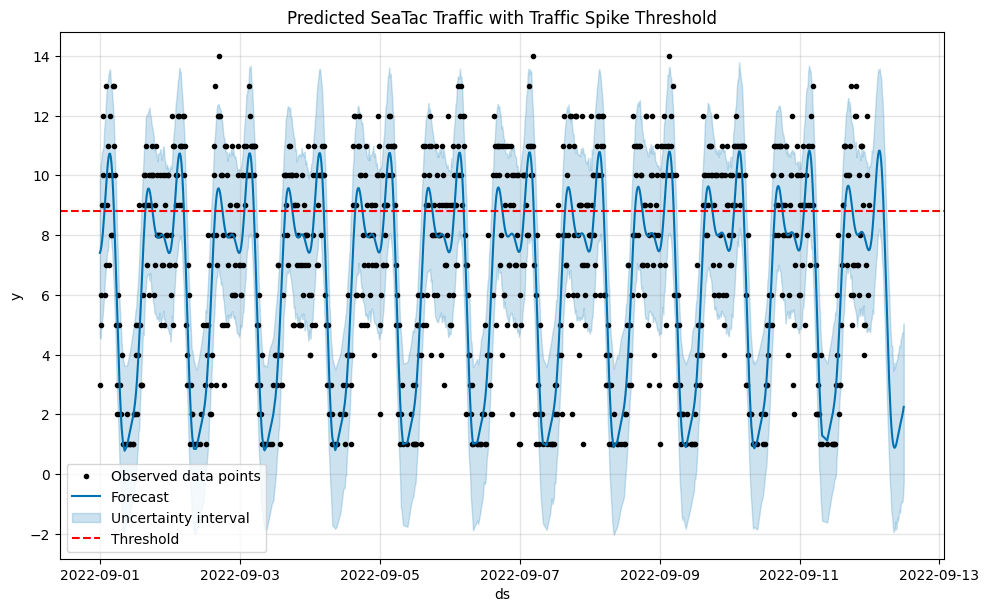

In [62]:
from prophet import Prophet

# Fit Prophet model to traffic
model = Prophet()
model.fit(traffic)

# 48 periods of 15 minutes, giving us 12 hours of forecasting 
future = model.make_future_dataframe(periods=48, freq='15min')
forecast = model.predict(future)

# Utilize mean and standard deviation to determine if traffic
# is spiking
meanTraffic = traffic['y'].mean()
stdTraffic = traffic['y'].std()

# Add half a standard deviation to mean as our threshold value
threshold = meanTraffic + 0.5 * stdTraffic
forecast['spike'] = forecast['yhat'] > threshold

# Create plot that showcases model, threshold, data points, and 
# an uncertainty interval
fig1 = model.plot(forecast)
plt.axhline(threshold, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.title("Predicted SeaTac Traffic with Traffic Spike Threshold")
plt.show()


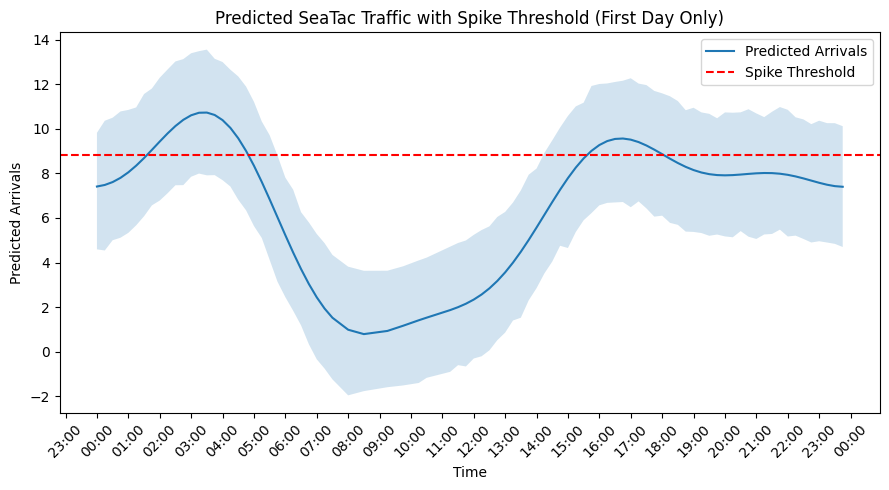

In [63]:
import matplotlib.dates as mdates

# Create a plot that shows just the first day of traffic
dayOne = forecast[forecast['ds'].dt.date == forecast['ds'].dt.date.min()].copy()


fig2 = plt.figure(figsize=(9, 5))
plt.plot(dayOne['ds'], dayOne['yhat'], label='Predicted Arrivals')
plt.fill_between(dayOne['ds'], dayOne['yhat_lower'], dayOne['yhat_upper'], alpha=0.2)
plt.axhline(threshold, color='r', linestyle='--', label='Spike Threshold')
plt.xlabel("Time")
plt.ylabel("Predicted Arrivals")
plt.title("Predicted SeaTac Traffic with Spike Threshold (First Day Only)")

# Change format of time shown
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator())

plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [64]:
# Simple function to define how to deal with traffic spikes in 
# our recommendation metric based on the model
def recommend(row):
    if row['spike']:
        return "Likely traffic spike, delay or reroute"
    else:
        return "Normal traffic"

forecast['recommendation'] = forecast.apply(recommend, axis=1)

# Create and save a .csv file with recommendations
forecast[['ds', 'yhat', 'spike', 'recommendation']].to_csv("trafficRecs.csv", index=False)

In [65]:
df2 = pd.read_csv("trafficRecs.csv")
df2.head(30)

,ds,yhat,spike,recommendation
0,2022-09-01 00:00:00,7.410894,False,Normal traffic
1,2022-09-01 00:15:00,7.481318,False,Normal traffic
2,2022-09-01 00:30:00,7.610621,False,Normal traffic
3,2022-09-01 00:45:00,7.800470,False,Normal traffic
4,2022-09-01 01:00:00,8.048478,False,Normal traffic
5,2022-09-01 01:15:00,8.348028,False,Normal traffic
6,2022-09-01 01:30:00,8.688370,False,Normal traffic
7,2022-09-01 01:45:00,9.054997,True,"Likely traffic spike, delay or reroute"
8,2022-09-01 02:00:00,9.430282,True,"Likely traffic spike, delay or reroute"
9,2022-09-01 02:15:00,9.794337,True,"Likely traffic spike, delay or reroute"
